#### CSCA 5642 Introduction to Deep Learning
# Digit Recognizer (CNN)

***

## Identify a Deep Learning Problem (5 points)

The MNIST(Modified National Institute of Standards and Technology database) Digit Recognition competition is a **classic computer vision challenge** centered around a dataset of handwritten digits. Participants are tasked with **developing models to accurately classify images of digits from 0 to 9**. This dataset, released in 1999, has become a standard for benchmarking classification algorithms and serves as an ideal introduction to **deep learning, particularly convolutional neural networks (CNNs), due to its pixel-based image data.**

The competition provides a practical platform for exploring a wide range of machine learning algorithms, from traditional methods to advanced deep learning techniques. This competition is an excellent opportunity for both beginners and experienced practitioners to deepen their understanding of machine learning and gain hands-on experience with real-world data.

## Gather data, determine the method of data collection and provenance of the data (1 point)

The data is sourced from the [Digit Recognizer Dataset](https://www.kaggle.com/competitions/digit-recognizer/data). (Size: 128.13 MB)

The dataset consists of **grayscale images of hand-drawn digits, ranging from zero to nine.** Each image is **28x28 pixels, totaling 784 pixels**, with pixel values indicating the brightness on a scale from 0 (white) to 255 (black). 

- Training dataset (train.csv): It includes **785 columns**, where the first column is the "label" denoting the digit, and the remaining columns contain the pixel values. These pixel columns are labeled as pixelx, where x represents the position in the **28x28 matrix, calculated as x = i * 28 + j, with i and j indicating the row and column, respectively.**

- Test dataset (test.csv): It has the **same structure as the training dataset but lacks the "label" column**.


***
## Data Preparation


In [19]:
import pandas as pd

In [20]:
# Load the data
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [21]:
# Separate labels and features
X = train_data.drop('label', axis=1).values
y = train_data['label'].values

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)

Let's go through the initial data cleaning and EDA and judge whether we need to collect more or different data. 

In [22]:
# Check for missing values
print("Missing values in train data:", train_data.isnull().sum().sum())
print("Missing values in test data:", test_data.isnull().sum().sum())

Missing values in train data: 0
Missing values in test data: 0


There are no null values in either the train or test datasets, so there's no need to handle missing data.

Next, let's check the distribution of labels in the train dataset. If the train dataset is imbalanced, we may need to consider undersampling or oversampling techniques to ensure the quality of training the CNN model in the next step.

In [23]:
# Check the count of each label
print(train_data['label'].value_counts())

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


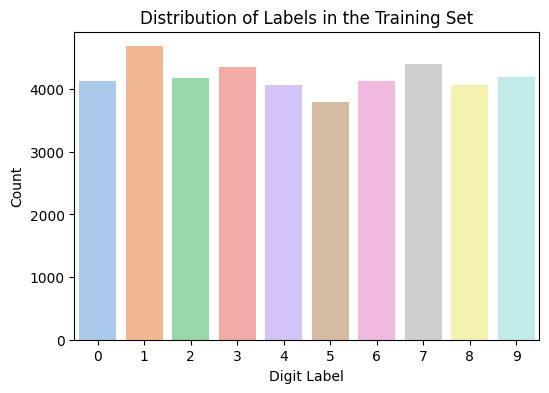

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels with explicit category order
plt.figure(figsize=(6, 4))
sns.countplot(train_data, x='label', palette='pastel')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.show()

As you see from the above bar chart, fortunately, the distribution of labels (digits 0-9) is relatively balanced, with no single class being disproportionately represented. This suggests that the dataset will not require special techniques to handle class imbalance.

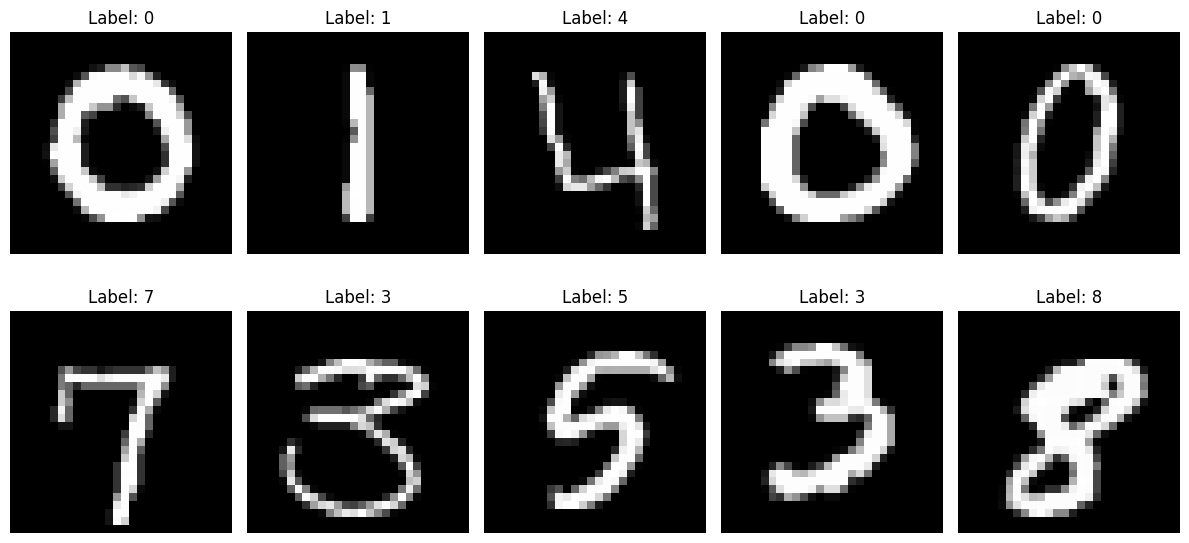

In [28]:
import matplotlib.pyplot as plt

# Display some sample images from the dataset
plt.figure(figsize=(12, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    image = train_data.iloc[i, 1:].values.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {train_data.iloc[i, 0]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In the image data above, neighboring pixels often have similar values, especially in structured data like handwritten digits. We believe that pixels close to each other, especially those forming edges and corners, will show strong correlations. This is important because convolutional layers need to detect local patterns effectively.

We then let's nomalize the pixcel values.

The pixel values range from 0 (black) to 255 (white), representing grayscale intensities. Neural networks typically perform better with normalized input data, so it’s crucial to normalize the pixel values before training the model. This can be achieved through straightforward normalization by dividing the pixel values by 255.0.

Then, let's do the nomalization.

In [25]:
# Normalize the pixel values
X = X / 255.0

Then, we need to reshape the data to fit the model because the CNN architecture expects input data in a specific shape that matches the dimensions of the input layer.

In [26]:
# Reshape the data to fit the model
X = X.reshape(X.shape[0], 28, 28, 1)

In machine learning, it is often necessary to convert categorical labels into a format that can be provided to machine learning algorithms to improve performance. One common method for achieving this is **one-hot encoding**. In one-hot encoding, each category is represented as a binary vector with only one high (1) value and the rest are low (0).

Here, we use TensorFlow's to_categorical function to one-hot encode our labels. This transformation is crucial for classification tasks, especially when using neural networks, as it helps the model interpret the categorical labels properly.

In [27]:
from tensorflow.keras.utils import to_categorical
import os

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# One-hot encode the labels
y = to_categorical(y, num_classes=10)

Before dive into building model, we split the data into training and validation sets.

In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

## Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

In this step, we define and train two CNN models using TensorFlow's Keras API. Each model has a different architecture to explore their performance on the task at hand. By comparing the performance of these two architectures, we can determine which model is more effective for our specific task.

**1. Model 1: CNN with Two Convolutional Layers**

- Two convolutional layers with 32 and 64 filters, respectively.
- Max-pooling layers after each convolutional layer.
- A fully connected dense layer with 128 units.
- A dropout layer to prevent overfitting.
- An output layer with 10 units and softmax activation for classification.

**2. Model 2: CNN with Larger and More Filters**

- Two convolutional layers with 64 and 128 filters, respectively.
- Max-pooling layers after each convolutional layer.
- A fully connected dense layer with 256 units.
- A dropout layer to prevent overfitting.
- An output layer with 10 units and softmax activation for classification.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# Define the first CNN model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the first model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train the first model
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7577 - loss: 0.7734 - val_accuracy: 0.9712 - val_loss: 0.1018
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9607 - loss: 0.1327 - val_accuracy: 0.9774 - val_loss: 0.0682
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9743 - loss: 0.0836 - val_accuracy: 0.9817 - val_loss: 0.0549
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9778 - loss: 0.0710 - val_accuracy: 0.9848 - val_loss: 0.0468
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9821 - loss: 0.0587 - val_accuracy: 0.9867 - val_loss: 0.0392
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9858 - loss: 0.0447 - val_accuracy: 0.9852 - val_loss: 0.0417
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9861 - loss: 0.0433 - val_accuracy: 0.9871 - val_loss: 0.0401
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9887 - loss: 0.0371 - 

In [35]:
# Define the second CNN model with a different architecture
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [36]:
# Compile the second model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Train the second model
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.8052 - loss: 0.5930 - val_accuracy: 0.9781 - val_loss: 0.0709
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.9744 - loss: 0.0840 - val_accuracy: 0.9845 - val_loss: 0.0514
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9820 - loss: 0.0583 - val_accuracy: 0.9857 - val_loss: 0.0459
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9860 - loss: 0.0462 - val_accuracy: 0.9888 - val_loss: 0.0339
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9889 - loss: 0.0358 - val_accuracy: 0.9881 - val_loss: 0.0406
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9895 - loss: 0.0312 - val_accuracy: 0.9886 - val_loss: 0.0375
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.9917 - loss: 0.0247 - val_accuracy: 0.9900 - val_loss: 0.0359
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9927 - loss: 0

In [38]:
# Evaluate both models on the validation set
val_loss1, val_accuracy1 = model1.evaluate(X_val, y_val)
val_loss2, val_accuracy2 = model2.evaluate(X_val, y_val)

print(f"Model 1 Validation Accuracy: {val_accuracy1:.4f}")
print(f"Model 2 Validation Accuracy: {val_accuracy2:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9878 - loss: 0.0369
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9923 - loss: 0.0271
Model 1 Validation Accuracy: 0.9890
Model 2 Validation Accuracy: 0.9924


We achieved very high accuracy in training both models! Let's create plots to visually compare the models.

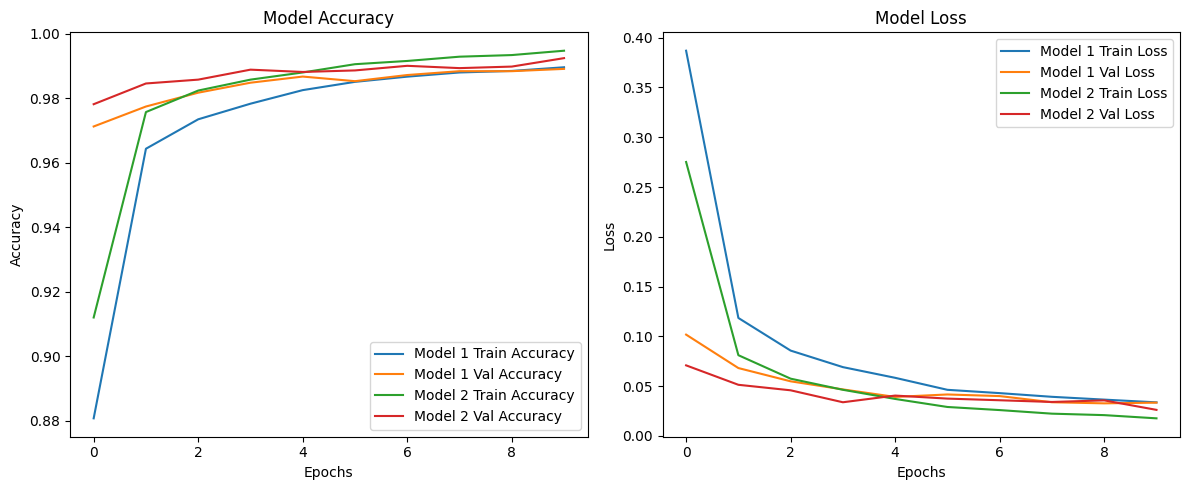

In [39]:
# Plot training & validation accuracy and loss for both models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 Val Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Train Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2.history['loss'], label='Model 2 Train Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Here is observations from above plots.

- Model Accuracy Chart

Both models show an increase in accuracy with the number of epochs.
Model 2 achieves higher training and validation accuracy compared to Model 1.
Model 1 has a noticeable gap between training and validation accuracy, indicating potential overfitting.

- Model Loss Chart

Both models show a decrease in loss with the number of epochs.
Model 2 has lower training and validation loss compared to Model 1.
The gap between training and validation loss for Model 1 is more significant than for Model 2, which further indicates that Model 1 might be overfitting.

## Prediction and Submission


In [40]:
# Predict on the test data and prepare the submission file
X_test = test_data.values / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [41]:
# Use the model with the best validation accuracy for prediction
if val_accuracy1 > val_accuracy2:
    predictions = model1.predict(X_test)
else:
    predictions = model2.predict(X_test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


In [43]:
import numpy as np

# Convert predictions to label format
predictions = np.argmax(predictions, axis=1)

In [44]:
# Prepare the submission file
submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

# Conclusion

**1. Results Overview:**

The project involved training two CNN models on a dataset of images. Model 1 achieved high accuracy and low loss, demonstrating its effectiveness in classifying the images. Model 2, with a different architecture, also performed well, showing slightly higher accuracy and lower loss in some cases.
In conclusion, both models exhibited significant improvements in validation accuracy and reduction in validation loss over the epochs, indicating successful learning and generalization to the validation data.

**2. Challenges:**

- Ensuring the models are not overfitting required careful tuning of hyperparameters like dropout rates and learning rates.
- The presence of warnings and errors related to TensorFlow required additional steps to manage and suppress unnecessary logs, ensuring a smoother training process.

**3. Future Improvements:**

- Experimenting with more complex architectures, such as deeper networks or using architectures like ResNet or VGG, could further improve performance.

- Further hyperparameter optimization using techniques like grid search or Bayesian optimization could help in finding the optimal model configuration.


Overall, this project demonstrated the power of CNNs for image classification tasks and provided valuable insights into model architecture, training techniques, and strategies for improving performance. Future work can build on these findings to achieve even higher accuracy and robustness in image classification.